In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import tensorflow as tf
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, classification_report
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.layers import (LSTM, Dense, Concatenate, Attention, Dropout, Softmax,
                                     Input, Flatten, Activation, Bidirectional, Permute, multiply, 
                                     ConvLSTM2D, MaxPooling3D, TimeDistributed, Conv2D, MaxPooling2D)

from scipy import stats

# disable some of the tf/keras training warnings 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3"
tf.get_logger().setLevel("ERROR")
tf.autograph.set_verbosity(1)

# suppress untraced functions warning
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [2]:
# Pre-trained pose estimation model from Google Mediapipe
mp_pose = mp.solutions.pose

# Supported Mediapipe visualization tools
mp_drawing = mp.solutions.drawing_utils

In [3]:
def mediapipe_detection(image, model):
    """
    This function detects human pose estimation keypoints from webcam footage
    
    """
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_landmarks(image, results):
    """
    This function draws keypoints and landmarks detected by the human pose estimation model
    
    """
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                 )

In [6]:
cap = cv2.VideoCapture(0) # camera object
HEIGHT = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) # webcam video frame height
WIDTH = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) # webcam video frame width
FPS = int(cap.get(cv2.CAP_PROP_FPS)) # webcam video fram rate 

# Set and test mediapipe model using webcam
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
      
        # Make detection
        image, results = mediapipe_detection(frame, pose)
        
        # Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark
        except:
            pass
        
        # Render detections
        draw_landmarks(image, results)               
        
        # Display frame on screen
        cv2.imshow('OpenCV Feed', image)
        
        # Exit / break out logic
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

In [7]:
# Recollect and organize keypoints from the test
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [8]:
# 33 landmarks with 4 values (x, y, z, visibility)
num_landmarks = len(landmarks)
num_values = len(test)
num_input_values = num_landmarks*num_values

In [9]:
# This is an example of what we would use as an input into our AI models
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)

In [10]:
def extract_keypoints(results):
    """
    Processes and organizes the keypoints detected from the pose estimation model 
    to be used as inputs for the exercise decoder models
    
    """
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    return pose

In [85]:
DATA_PATH = os.path.join(os. getcwd(),'data') 
print(DATA_PATH)

# make directory if it does not exist yet
if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)

# Actions/exercises that we try to detect
actions = np.array(['curl', 'press', 'squat'])
num_classes = len(actions)

# How many videos worth of data
no_sequences = 30

# Videos are going to be this many frames in length
sequence_length = 50

# Folder start
# Change this to collect more data and not lose previously collected data
start_folder = 100

C:\Users\neeshu\data


In [86]:
for action in actions:     
    for sequence in range(start_folder,no_sequences+start_folder):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))  
        except:
            pass

In [87]:
colors = [(245,117,16), (117,245,16), (16,117,245)]

In [88]:

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    # Loop through actions
    for idx, action in enumerate(actions):
        # Loop through sequences (i.e., videos)
        for sequence in range(start_folder, start_folder+no_sequences):
            # Loop through video length (i.e, sequence length)
            for frame_num in range(sequence_length):
                # Read feed
                ret, frame = cap.read()
                
                # Make detection
                image, results = mediapipe_detection(frame, pose)

                # Extract landmarks
                try:
                    landmarks = results.pose_landmarks.landmark
                except:
                    pass
                
                # Render detections
                draw_landmarks(image, results) 

                # Apply visualization logic
                if frame_num == 0: # If first frame in sequence, print that you're starting a new data collection and wait 500 ms
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    
                    cv2.putText(image, 'Collecting {} Video # {}'.format(action, sequence), (15,30), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 8, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting {} Video # {}'.format(action, sequence), (15,30), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, colors[idx], 4, cv2.LINE_AA)
                    
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else: 
                    cv2.putText(image, 'Collecting {} Video # {}'.format(action, sequence), (15,30), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 8, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting {} Video # {}'.format(action, sequence), (15,30), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, colors[idx], 4, cv2.LINE_AA)
                    
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)

                # Export keypoints (sequence + pose landmarks)
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [89]:
print(actions)
label_map = {label:num for num, label in enumerate(actions)}

['curl' 'press' 'squat']


In [90]:
# Load and organize recorded training data
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(50):         
            # LSTM input data
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)  
            
        sequences.append(window)
        labels.append(label_map[action])

In [91]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)
print(X.shape, y.shape)

(90, 50, 132) (90, 3)


In [92]:
# Split into training, validation, and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print(X_train.shape, y_train.shape)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=2)
print(X_val,y_val)

(63, 50, 132) (63, 3)
[[[ 3.28765035e-01  7.88559258e-01 -8.33130717e-01 ...  2.54834795e+00
   -1.95110187e-01  6.27376779e-04]
  [ 3.45363438e-01  8.05736959e-01 -7.33750045e-01 ...  1.77311707e+00
    6.03060536e-02  2.58438825e-03]
  [ 3.43573332e-01  8.02042365e-01 -8.85321319e-01 ...  1.70183563e+00
    1.09627284e-01  3.39871552e-03]
  ...
  [ 3.66844654e-01  8.21886599e-01 -4.92622674e-01 ...  2.37112522e+00
    6.60919249e-02  4.74685105e-04]
  [ 3.65430146e-01  8.13532293e-01 -5.14626145e-01 ...  2.37214828e+00
   -2.24806312e-02  4.34844464e-04]
  [ 3.59031409e-01  8.13523412e-01 -5.62411427e-01 ...  2.37349319e+00
   -5.80658726e-02  4.05611965e-04]]

 [[-1.19111001e-01  6.01000130e-01 -1.00856769e+00 ...  2.57161546e+00
   -6.66385442e-02  1.98342698e-03]
  [-1.17608212e-01  6.02764487e-01 -9.20486808e-01 ...  2.58842421e+00
   -2.39291117e-01  1.91632262e-03]
  [-1.14401147e-01  5.99658728e-01 -8.38410556e-01 ...  2.58744168e+00
   -1.61766067e-01  1.79633615e-03]
  ...
 

In [93]:
# Callbacks to be used during neural network training 
es_callback = EarlyStopping(monitor='val_loss', min_delta=5e-4, patience=10, verbose=0, mode='min')
lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=0, mode='min')
chkpt_callback = ModelCheckpoint(filepath=DATA_PATH, monitor='val_loss', verbose=0, save_best_only=True, 
                                 save_weights_only=False, mode='min', save_freq=1)

# Optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

# some hyperparamters
batch_size = 5
max_epochs = 200

In [94]:
# Set up Tensorboard logging and callbacks
NAME = f"ExerciseRecognition-LSTM-{int(time.time())}"
log_dir = os.path.join(os.getcwd(), 'logs', NAME,'')
tb_callback = TensorBoard(log_dir=log_dir)

callbacks = [tb_callback, es_callback, lr_callback, chkpt_callback]

In [95]:
lstm = Sequential()
lstm.add(LSTM(128, return_sequences=True, activation='relu', input_shape=(sequence_length, num_input_values)))
lstm.add(LSTM(256, return_sequences=True, activation='relu'))
lstm.add(LSTM(128, return_sequences=False, activation='relu'))
lstm.add(Dense(128, activation='relu'))
lstm.add(Dense(64, activation='relu'))
lstm.add(Dense(actions.shape[0], activation='softmax'))
print(lstm.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 50, 128)           133632    
                                                                 
 lstm_22 (LSTM)              (None, 50, 256)           394240    
                                                                 
 lstm_23 (LSTM)              (None, 128)               197120    
                                                                 
 dense_27 (Dense)            (None, 128)               16512     
                                                                 
 dense_28 (Dense)            (None, 64)                8256      
                                                                 
 dense_29 (Dense)            (None, 3)                 195       
                                                                 
Total params: 749,955
Trainable params: 749,955
Non-tr

Epoch 1/100
3/3 [==============================] - 28s 2s/step - loss: 1.0893 - categorical_accuracy: 0.4151 - val_loss: 1.0996 - val_categorical_accuracy: 0.2000 - lr: 1.0000e-04
Epoch 2/100
3/3 [==============================] - 1s 498ms/step - loss: 1.0709 - categorical_accuracy: 0.4717 - val_loss: 1.1016 - val_categorical_accuracy: 0.2000 - lr: 1.0000e-04
Epoch 3/100
3/3 [==============================] - 1s 357ms/step - loss: 1.0568 - categorical_accuracy: 0.4528 - val_loss: 1.1050 - val_categorical_accuracy: 0.2000 - lr: 1.0000e-04
Epoch 4/100
3/3 [==============================] - 4s 2s/step - loss: 1.0384 - categorical_accuracy: 0.4528 - val_loss: 1.1095 - val_categorical_accuracy: 0.2000 - lr: 1.0000e-04
Epoch 5/100
3/3 [==============================] - 1s 553ms/step - loss: 1.0088 - categorical_accuracy: 0.4528 - val_loss: 1.1187 - val_categorical_accuracy: 0.2000 - lr: 1.0000e-04
Epoch 6/100
3/3 [==============================] - 4s 2s/step - loss: 0.9683 - categorical_accu

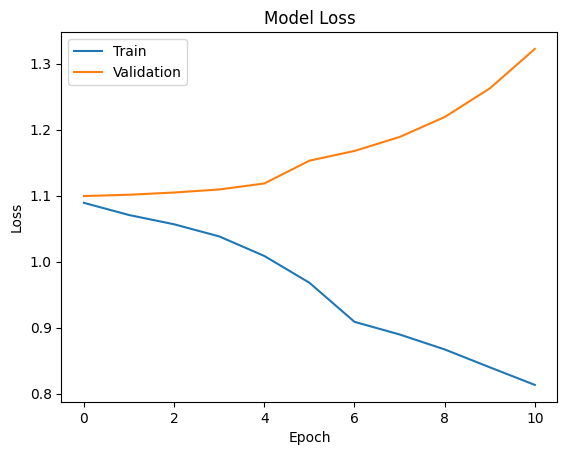

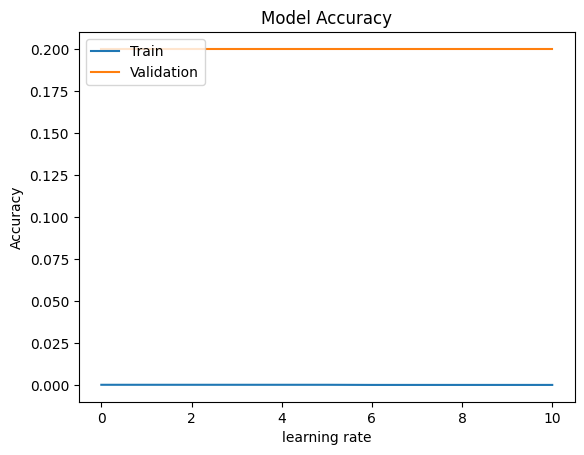

In [96]:
import matplotlib.pyplot as plt

lstm.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history = lstm.fit(X_train, y_train, batch_size=20, epochs=100, validation_data=(X_val, y_val), callbacks=callbacks)

# Plot the loss over time
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['lr'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('learning rate')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [97]:
# Set up Tensorboard logging and callbacks
NAME = f"ExerciseRecognition-AttnLSTM-{int(time.time())}"
log_dir = os.path.join(os.getcwd(), 'logs', NAME,'')
tb_callback = TensorBoard(log_dir=log_dir)

callbacks = [tb_callback, es_callback, lr_callback, chkpt_callback]

In [98]:
def attention_block(inputs, time_steps):
    """
    Attention layer for deep neural network
    
    """
    # Attention weights
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax')(a)
    
    # Attention vector
    a_probs = Permute((2, 1), name='attention_vec')(a)
    
    # Luong's multiplicative score
    output_attention_mul = multiply([inputs, a_probs], name='attention_mul') 
    
    return output_attention_mul

In [99]:
HIDDEN_UNITS = 256

# Input
inputs = Input(shape=(sequence_length, num_input_values))

# Bi-LSTM
lstm_out = Bidirectional(LSTM(HIDDEN_UNITS, return_sequences=True))(inputs)

# Attention
attention_mul = attention_block(lstm_out, sequence_length)
attention_mul = Flatten()(attention_mul)

# Fully Connected Layer
x = Dense(2*HIDDEN_UNITS, activation='relu')(attention_mul)
x = Dropout(0.5)(x)

# Output
x = Dense(actions.shape[0], activation='softmax')(x)

# Bring it all together
AttnLSTM = Model(inputs=[inputs], outputs=x)
print(AttnLSTM.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 50, 132)]    0           []                               
                                                                                                  
 bidirectional_3 (Bidirectional  (None, 50, 512)     796672      ['input_4[0][0]']                
 )                                                                                                
                                                                                                  
 permute_3 (Permute)            (None, 512, 50)      0           ['bidirectional_3[0][0]']        
                                                                                                  
 dense_30 (Dense)               (None, 512, 50)      2550        ['permute_3[0][0]']        

In [ ]:
AttnLSTM.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history = AttnLSTM.fit(X_train, y_train, batch_size=5, epochs=40, validation_data=(X_val, y_val), callbacks=callbacks)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('learning rate')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Model map
models = {
    'LSTM': lstm, 
    'LSTM_Attention_128HUs': AttnLSTM, 
}

In [ ]:
for model_name, model in models.items():
    save_dir = os.path.join(os.getcwd(), f"{model_name}.h5")
    model.save(save_dir)

In [ ]:
for model_name, model in models.items():
    load_dir = os.path.join(os.getcwd(), f"{model_name}.h5")
    model.load_weights(load_dir)

In [ ]:
for model in models.values():
    res = model.predict(X_test, verbose=0) 

In [ ]:
eval_results = {}
eval_results['confusion matrix'] = None
eval_results['accuracy'] = None
eval_results['precision'] = None
eval_results['recall'] = None
eval_results['f1 score'] = None

confusion_matrices = {}
classification_accuracies = {}   
precisions = {}
recalls = {}
f1_scores = {} 

In [ ]:
for model_name, model in models.items():
    yhat = model.predict(X_test, verbose=0)
    
    # Get list of classification predictions
    ytrue = np.argmax(y_test, axis=1).tolist()
    yhat = np.argmax(yhat, axis=1).tolist()
    
    # Confusion matrix
    confusion_matrices[model_name] = multilabel_confusion_matrix(ytrue, yhat)
    print(f"{model_name} confusion matrix: {os.linesep}{confusion_matrices[model_name]}")

# Collect results 
eval_results['confusion matrix'] = confusion_matrices

In [ ]:
for model_name, model in models.items():
    yhat = model.predict(X_test, verbose=0)
    
    # Get list of classification predictions
    ytrue = np.argmax(y_test, axis=1).tolist()
    yhat = np.argmax(yhat, axis=1).tolist()
    
    # Model accuracy
    classification_accuracies[model_name] = accuracy_score(ytrue, yhat)    
    print(f"{model_name} classification accuracy = {round(classification_accuracies[model_name]*100,3)}%")

# Collect results 
eval_results['accuracy'] = classification_accuracies

In [ ]:
for model_name, model in models.items():
    yhat = model.predict(X_test, verbose=0)
    
    # Get list of classification predictions
    ytrue = np.argmax(y_test, axis=1).tolist()
    yhat = np.argmax(yhat, axis=1).tolist()
    
    # Precision, recall, and f1 score
    report = classification_report(ytrue, yhat, target_names=actions, output_dict=True)
    
    precisions[model_name] = report['weighted avg']['precision']
    recalls[model_name] = report['weighted avg']['recall']
    f1_scores[model_name] = report['weighted avg']['f1-score'] 
   
    print(f"{model_name} weighted average precision = {round(precisions[model_name],3)}")
    print(f"{model_name} weighted average recall = {round(recalls[model_name],3)}")
    print(f"{model_name} weighted average f1-score = {round(f1_scores[model_name],3)}\n")

# Collect results 
eval_results['precision'] = precisions
eval_results['recall'] = recalls
eval_results['f1 score'] = f1_scores

In [ ]:
model = AttnLSTM
model_name = 'AttnLSTM'

In [ ]:
def calculate_angle(a,b,c):
    """
    Computes 3D joint angle inferred by 3 keypoints and their relative positions to one another
    
    """
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle >180.0:
        angle = 360-angle
        
    return angle 

In [ ]:

def get_coordinates(landmarks, mp_pose, side, joint):
    """
    Retrieves x and y coordinates of a particular keypoint from the pose estimation model
         
     Args:
         landmarks: processed keypoints from the pose estimation model
         mp_pose: Mediapipe pose estimation model
         side: 'left' or 'right'. Denotes the side of the body of the landmark of interest.
         joint: 'shoulder', 'elbow', 'wrist', 'hip', 'knee', or 'ankle'. Denotes which body joint is associated with the landmark of interest.
    
    """
    coord = getattr(mp_pose.PoseLandmark,side.upper()+"_"+joint.upper())
    x_coord_val = landmarks[coord.value].x
    y_coord_val = landmarks[coord.value].y
    return [x_coord_val, y_coord_val]   

In [43]:
def viz_joint_angle(image, angle, joint):
    """
    Displays the joint angle value near the joint within the image frame
    
    """
    cv2.putText(image, str(int(angle)), 
                   tuple(np.multiply(joint, [640, 480]).astype(int)), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                        )
    return

In [44]:
def count_reps(image, current_action, landmarks, mp_pose):
    """
    Counts repetitions of each exercise. Global count and stage (i.e., state) variables are updated within this function.
    
    """

    global curl_counter, press_counter, squat_counter, curl_stage, press_stage, squat_stage
    
    if current_action == 'curl':
        # Get coords
        shoulder = get_coordinates(landmarks, mp_pose, 'left', 'shoulder')
        elbow = get_coordinates(landmarks, mp_pose, 'left', 'elbow')
        wrist = get_coordinates(landmarks, mp_pose, 'left', 'wrist')
        
        # calculate elbow angle
        angle = calculate_angle(shoulder, elbow, wrist)
        
        # curl counter logic
        if angle < 30:
            curl_stage = "up" 
        if angle > 140 and curl_stage =='up':
            curl_stage="down"  
            curl_counter +=1
        press_stage = None
        squat_stage = None
            
        # Viz joint angle
        viz_joint_angle(image, angle, elbow)
        
    elif current_action == 'press':
        
        # Get coords
        shoulder = get_coordinates(landmarks, mp_pose, 'left', 'shoulder')
        elbow = get_coordinates(landmarks, mp_pose, 'left', 'elbow')
        wrist = get_coordinates(landmarks, mp_pose, 'left', 'wrist')

        # Calculate elbow angle
        elbow_angle = calculate_angle(shoulder, elbow, wrist)
        
        # Compute distances between joints
        shoulder2elbow_dist = abs(math.dist(shoulder,elbow))
        shoulder2wrist_dist = abs(math.dist(shoulder,wrist))
        
        # Press counter logic
        if (elbow_angle > 130) and (shoulder2elbow_dist < shoulder2wrist_dist):
            press_stage = "up"
        if (elbow_angle < 50) and (shoulder2elbow_dist > shoulder2wrist_dist) and (press_stage =='up'):
            press_stage='down'
            press_counter += 1
        curl_stage = None
        squat_stage = None
            
        # Viz joint angle
        viz_joint_angle(image, elbow_angle, elbow)
        
    elif current_action == 'squat':
        # Get coords
        # left side
        left_shoulder = get_coordinates(landmarks, mp_pose, 'left', 'shoulder')
        left_hip = get_coordinates(landmarks, mp_pose, 'left', 'hip')
        left_knee = get_coordinates(landmarks, mp_pose, 'left', 'knee')
        left_ankle = get_coordinates(landmarks, mp_pose, 'left', 'ankle')
        # right side
        right_shoulder = get_coordinates(landmarks, mp_pose, 'right', 'shoulder')
        right_hip = get_coordinates(landmarks, mp_pose, 'right', 'hip')
        right_knee = get_coordinates(landmarks, mp_pose, 'right', 'knee')
        right_ankle = get_coordinates(landmarks, mp_pose, 'right', 'ankle')
        
        # Calculate knee angles
        left_knee_angle = calculate_angle(left_hip, left_knee, left_ankle)
        right_knee_angle = calculate_angle(right_hip, right_knee, right_ankle)
        
        # Calculate hip angles
        left_hip_angle = calculate_angle(left_shoulder, left_hip, left_knee)
        right_hip_angle = calculate_angle(right_shoulder, right_hip, right_knee)
        
        # Squat counter logic
        thr = 165
        if (left_knee_angle < thr) and (right_knee_angle < thr) and (left_hip_angle < thr) and (right_hip_angle < thr):
            squat_stage = "down"
        if (left_knee_angle > thr) and (right_knee_angle > thr) and (left_hip_angle > thr) and (right_hip_angle > thr) and (squat_stage =='down'):
            squat_stage='up'
            squat_counter += 1
        curl_stage = None
        press_stage = None
            
        # Viz joint angles
        viz_joint_angle(image, left_knee_angle, left_knee)
        viz_joint_angle(image, left_hip_angle, left_hip)
        
    else:
        pass

In [45]:
def prob_viz(res, actions, input_frame, colors):
    """
    This function displays the model prediction probability distribution over the set of exercise classes
    as a horizontal bar graph
    
    """
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):        
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [46]:

# 1. New detection variables
sequence = []
predictions = []
res = []
threshold = 0.5 # minimum confidence to classify as an action/exercise
current_action = ''

# Rep counter logic variables
curl_counter = 0
press_counter = 0
squat_counter = 0
curl_stage = None
press_stage = None
squat_stage = None

# Camera object
cap = cv2.VideoCapture(0)

# Video writer object that saves a video of the real time test
fourcc = cv2.VideoWriter_fourcc('M','J','P','G') # video compression format
HEIGHT = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) # webcam video frame height
WIDTH = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) # webcam video frame width
FPS = int(cap.get(cv2.CAP_PROP_FPS)) # webcam video fram rate 

video_name = os.path.join(os.getcwd(),f"{model_name}_real_time_test.avi")
out = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*"MJPG"), FPS, (WIDTH,HEIGHT))

# Set mediapipe model 
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detection
        image, results = mediapipe_detection(frame, pose)
        
        # Draw landmarks
        draw_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)        
        sequence.append(keypoints)      
        sequence = sequence[-sequence_length:]
              
        if len(sequence) == sequence_length:
            res = model.predict(np.expand_dims(sequence, axis=0), verbose=0)[0]           
            predictions.append(np.argmax(res))
            current_action = actions[np.argmax(res)]
            confidence = np.max(res)
            
        #3. Viz logic
            # Erase current action variable if no probability is above threshold
            if confidence < threshold:
                current_action = ''

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
            # Count reps
            try:
                landmarks = results.pose_landmarks.landmark
                count_reps(
                    image, current_action, landmarks, mp_pose)
            except:
                pass

            # Display graphical information
            cv2.rectangle(image, (0,0), (640, 40), colors[np.argmax(res)], -1)
            cv2.putText(image, 'curl ' + str(curl_counter), (3,30), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            cv2.putText(image, 'press ' + str(press_counter), (240,30), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            cv2.putText(image, 'squat ' + str(squat_counter), (490,30), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
         
        # Show to screen
        cv2.imshow('OpenCV Feed', image)
        
        # Write to video file
        if ret == True:
            out.write(image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    out.release()
    cv2.destroyAllWindows()